In [1]:
import pandas as pd
import numpy as np
import re
from importlib import import_module

import json

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, MaxNLocator
from matplotlib.lines import Line2D

In [2]:
RUNS = [
    (36,"3faf0d9266c1434ab553bcdb6aba07f0"),
    (37,"c4d4691ea56449b8bf004324f0d65b5f"),
    (38,"9e33a6b1e87642688bb3d20a927260f2"),
    (28,"2ff7de738e524c8493613c676cb9910a"),
    (28,"dc1787b74cc74ab8a75f65b06686349a"),
    (30,"c71ce1f121c94416a17afafa885059f9"),
    (30,"f4edc0c1909440bca950987d8de145fe"),
    (27,"5e43979bdbd94ba486dd963a5a55a507"),
    (29,"85b59ebd0db0465ab5a955b5c1c536bd"),
    (29,"b5f17c076c19411e98ecec6e49f53c08"),
    (38, "09ca9ad78fe343c2997c3ec47a77fdde"),
    (37, "4012e12f92a24e65bc2c5fb58a06492d"),
    (36, "954b1ba7dab64144972a55a8d05e39eb"),
    (40, "72704ed5b29f491fbc361b23de4b4ab4"),
    (41, "08eac58ec8c94e21afea824b86b8abb2"),
    (42, "604f99c7be8d470eba89fb9b79c9ec67"),
    (46, "ef6b164f6cb847579ddc85e9f1cec318"),
    (47, "723cd4bd5df944a1bb28fceada0077f0"),
    (48, "28135a00ac0c4933a417db943f734f8d"),
    (42, "0b54b5f516014a5c8d4c057e2aaa146a"),
    (41, "1a76387d25a846c09d559503e4578d5e"),
    (40, "c4f1afdaca844eb98702430ddff0904f"),
    (28, "ad535374b87b47b9ae6b26ac6bbba525"),
    (30, "254489b191824e6486fc1901adcfd9cf"),
    (29, "9aa08b5ad01645a5927f46f6f5633eb3"),
    (38, "b5b3c8a36de74b29b5420adeb44b7d22"),
    (37, "f03c609dd0384700b19d226ace451293"),
    (36, "56d64889a48d4548bba7e0a83b0c1ce3"),
    (47, "7213b8e73dca48dab8589d88472d17fb"),
    (48, "cd35a808f1b24657a83770d4fd77207a"),
    (46, "3e46c783f8e74a509099d1d41fde632e"),
    (42, "266a5e2e6a394ce298f5fe846c9ea346"),
    (41, "21686098fb8e49778e4f82b1a9b4f153"),
    (40, "c767c60054c54caebb9e2edeb515053b"),
    (47, "18c9b43215ae437c8801195b656db1b6"),
    (48, "e95b620b96094e3185eb94d650b3d379"),
    (46, "50930baae88f43b0ab9e490f5c698640")
]

RUN_TO_EXP = {x[1]: x[0] for x in RUNS}

EXP_CFG = {
    x: import_module(f"configs.cfg_{str(x).zfill(5)}").cfg for x in set([y[0] for y in RUNS])
}

RES_DIRS = [
    ("001", "Arithmetic Mean - Probe All Patches"),
    ("002", "Loss"),
    ("003", "Arithmetic Mean - Probe All Patches"),
    ("004", "Cos. Patch Similarity"),
    ("005", "Arithmetic Mean - Probe One Patch"),
    ("006", "Arithmetic Mean - Probe One Patch"),
    ("007", "Stats"),
    ("008", "CKA")
]

def get_df(res_dir, target_name):
    results = {}
    for run in RUNS:
        try:
            with open(f"results/{res_dir}/{run[1]}.json", "r", encoding="utf-8") as f:
                loaded_results = json.load(f)
            results[run[1]] = loaded_results
        except FileNotFoundError as e:
            continue            

    rows = []
    for uuid, datasets in results.items():
        for dataset_name, solvers in datasets.items():
            for solver_name, runs in solvers.items():
                for run_nr, run in runs.items():
                    for block_nr, metrics in run.items():
                        if isinstance(metrics, dict) and target_name[:14] == "Geometric Mean":
                            # find all keys like "cv_target_0_accuracy_mean", "cv_target_1_accuracy_mean", ...
                            target_means = []
                            for k, v in metrics.items():
                                if re.match(r"cv_target_\d+_accuracy_mean$", k):
                                    target_means.append(float(v))

                            if target_means:
                                # geometric mean of the target accuracies
                                target_val = float(np.prod(target_means) ** (1.0 / len(target_means)))
                            else:
                                target_val = np.nan  # or skip this row if you prefer
                        elif isinstance(metrics, dict) and target_name[:15] == "Arithmetic Mean":
                            target_means = []
                            for k, v in metrics.items():
                                if re.match(r"cv_target_\d+_accuracy_mean$", k):
                                    target_means.append(float(v))

                            if target_means:
                                target_val = float(np.mean(target_means))
                            else:
                                target_val = np.nan  # or skip this row if you prefer
                        elif isinstance(metrics, dict) and target_name == "Total Accuracy":
                            target_val = float(metrics["cv_overall_accuracy_mean"])
                        elif isinstance(metrics, dict) and target_name == "CKA":
                            target_val = metrics
                        elif isinstance(metrics, dict) and target_name == "Stats":
                            target_val = metrics
                        elif isinstance(metrics, float) and target_name in ["Loss", "Cos. Patch Similarity"]:
                            target_val = metrics
                        else:
                            raise ValueError("target val not matched")

                        exp_nr = RUN_TO_EXP[uuid]
                        cfg = EXP_CFG[exp_nr]

                        block_nr = int(block_nr)
                        layer_nr = cfg["model"]["blocks"][block_nr]["encoder"]["modules"][block_nr][-1] + 1
                        regime = cfg["train_cfg"]["regime"]
                        architecture = cfg["model"]["blocks"][block_nr]["encoder"]["architecture"]

                        if isinstance(target_val, float):
                            rows.append(
                                {
                                    "exp": exp_nr,
                                    "uuid": uuid,
                                    "dataset": dataset_name,
                                    "block_nr": block_nr + 1,
                                    "layer_nr": layer_nr,
                                    "solver": solver_name,
                                    "run_nr": run_nr, 
                                    "target_name": target_name,
                                    "target_val": target_val,
                                    "regime": regime,
                                    "res": res_dir,
                                    "architecture": architecture
                                }
                            )
                        elif isinstance(target_val, dict):
                            for k, v in target_val.items():
                                rows.append(
                                    {
                                        "exp": exp_nr,
                                        "uuid": uuid,
                                        "dataset": dataset_name,
                                        "block_nr": block_nr + 1,
                                        "layer_nr": layer_nr,
                                        "solver": solver_name,
                                        "run_nr": run_nr, 
                                        "target_name": k,
                                        "target_val": v,
                                        "regime": regime,
                                        "res": res_dir,
                                        "architecture": architecture
                                    }
                                )
                        else:
                            raise ValueError("target_val type not expected")


    df = pd.DataFrame(rows)

    if res_dir == "002":
        df = df.loc[~((df["layer_nr"] < 12) & (df["regime"] == "e2e_attached"))]
    
    if res_dir == "003":
        cond = df["solver"] == "logr"
        df = df.loc[cond]

    return df


all_dfs = []
for res_dir in RES_DIRS:
    all_dfs.append(get_df(res_dir[0], res_dir[1]))
df = pd.concat(all_dfs, axis=0, ignore_index=True)

sns.set_theme(
    context="paper",
    font_scale=1.25,
    style="whitegrid",
    rc={
        "axes.linewidth": 0.8,
        "grid.linewidth": 0.6,
        "lines.linewidth": 1.6,
        "lines.markersize": 4.0,
        "pdf.fonttype": 42,
        "ps.fonttype": 42,

        "font.size": 10.5,
        "axes.titlesize": 13.5,
        "axes.labelsize": 13.0,
        "xtick.labelsize": 13.0,
        "ytick.labelsize": 13.0,
        "legend.fontsize": 13.0,
        "legend.title_fontsize": 13.0,

        "axes.spines.top": False,
        "axes.spines.right": False,
        "xtick.direction": "out",
        "ytick.direction": "out",
    },
)

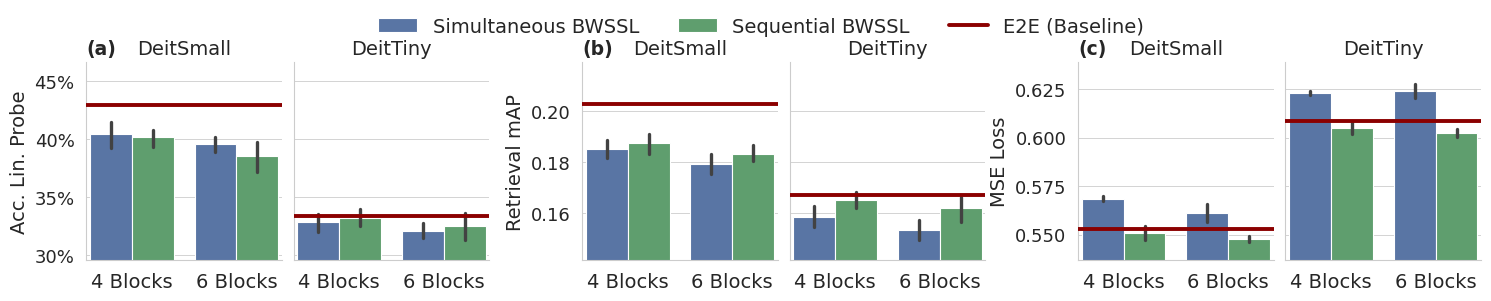

In [3]:
TARGET_NAME_LABEL = {
    "Loss": "MSE Loss", 
    "Arithmetic Mean - Probe All Patches": "Acc. Lin. Probe",
    "retrieval_map": "Retrieval mAP"
}


def multiaxis_bar(
    df: pd.DataFrame,
    other_col: str = "architecture",              # combine: other_col + target_name
    target_names: list[str] | None = None,  # optional: restrict/order targets
    other_vals: list[str] | None = None,    # optional: restrict/order regimes
):
    d = df.copy()

    # Optional filters (also define ordering)
    if target_names is not None:
        d = d[d["target_name"].isin(target_names)].copy()
    if other_vals is not None:
        d = d[d[other_col].isin(other_vals)].copy()

    other_order = (
        [v for v in other_vals if v in set(d[other_col].dropna())]
        if other_vals is not None
        else sorted(pd.unique(d[other_col].dropna()))
    )
    target_order = (
        [t for t in target_names if t in set(d["target_name"].dropna())]
        if target_names is not None
        else sorted(pd.unique(d["target_name"].dropna()))
    )

    existing_pairs = set(zip(d["target_name"], d[other_col]))
    panels = [(o, t) for t in target_order for o in other_order if (t, o) in existing_pairs]

    regimes = sorted(pd.unique(d["regime"].dropna()))
    palette = dict(zip(regimes, sns.color_palette(n_colors=len(regimes))))

    fig = plt.figure(figsize=(4*4.5, 3))
    outer = fig.add_gridspec(1, 3, wspace=0.23)

    axes = []
    for gi in range(3):
        inner = outer[0, gi].subgridspec(1, 2, wspace=0.06)
        ax_left  = fig.add_subplot(inner[0, 0])
        ax_right = fig.add_subplot(inner[0, 1], sharey=ax_left)
        axes.extend([ax_left, ax_right])

    regime_handles_labels = None

    pair_ranges = [[], [], []]
    panel_letters = list("abc")
    
    for i, (ax, (o, t)) in enumerate(zip(axes, panels)):
        pair_idx = i // 2
        mask = (d[other_col] == o) & (d["target_name"] == t)
        sub = d.loc[mask].copy()
        
        # --- NEW: split baseline (block_nr == 1) from bars (block_nr != 1) ---
        sub_line = sub[sub["block_nr"] == 1].copy()
        sub_bar  = sub[sub["block_nr"] != 1].copy()

        sub_bar["block_nr_cat"] = sub_bar["block_nr"].astype(str)
        block_order_sub = [str(b) for b in sorted(sub_bar["block_nr"].dropna().unique())]
        hue_order_sub = sorted(sub_bar["regime"].dropna().unique())

        sns.barplot(
            data=sub_bar,
            x="block_nr_cat",
            y="target_val",
            hue="regime",
            hue_order=hue_order_sub,
            palette=palette,
            order=block_order_sub,
            estimator="mean",
            errorbar=("ci", 95),
            ax=ax,
        )

        # Draw baseline as red horizontal line(s) ---
        if not sub_line.empty:
            # summarize baseline to one number per regime (mean)
            base = (sub_line.groupby("regime", as_index=False)["target_val"].mean())

            for _, row in base.iterrows():
                y0 = row["target_val"]
                ax.axhline(y0, color="darkred", linewidth=2.8, alpha=1.0, zorder=5)

        if i % 2 == 0:
            ax.set_title(f"({panel_letters[pair_idx]})", loc="left", fontweight="bold")
        else:
            ax.set_title("", loc="left")
        
        ax.text(
            0.5, 1.02, f"{o}",
            transform=ax.transAxes,
            ha="center", va="bottom",
            fontsize=14
        )
        ax.set_xlabel("")
        ax.set_xticks(range(len(block_order_sub)))
        ax.set_xticklabels([f"{b} Blocks" for b in block_order_sub], fontsize=14)
        # ax.set_ylabel("")
        if i % 2 == 0:
            ax.set_ylabel(TARGET_NAME_LABEL.get(t, t), fontsize=14)
        else:
            ax.set_ylabel("")
        ax.tick_params(axis="x")
        ax.margins(x=0.02)

        if regime_handles_labels is None:
            regime_handles_labels = ax.get_legend_handles_labels()
        leg = ax.get_legend()
        if leg is not None:
            leg.remove()

        y_vals = []
        if not sub_bar.empty:
            y_vals.append(sub_bar["target_val"].min())
            y_vals.append(sub_bar["target_val"].max())
        if not sub_line.empty:
            y_vals.append(sub_line["target_val"].min())
            y_vals.append(sub_line["target_val"].max())

        if y_vals:
            pair_ranges[pair_idx].append((min(y_vals), max(y_vals)))

    for ax in (axes[1], axes[3], axes[5]):
        ax.tick_params(axis="y", labelleft=False)
        ax.set_ylabel("")

    for p, (axL, axR) in enumerate([(axes[0], axes[1]), (axes[2], axes[3]), (axes[4], axes[5])]):
        if not pair_ranges[p]:
            continue
        ymin = min(r[0] for r in pair_ranges[p])
        ymax = max(r[1] for r in pair_ranges[p])

        span = ymax - ymin
        pad = 0.05 * span if span > 0 else 0.01  # fallback padding if values identical
        axL.set_ylim(ymin - pad, ymax + pad)
        if p == 0:
            for ax in (axL, axR):
                ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))
    
    if regime_handles_labels is not None:
        handles, labels = regime_handles_labels

        rename = {
            "concurrent": "Simultaneous BWSSL",
            "sequential": "Sequential BWSSL",
        }
        labels = [rename.get(l, l) for l in labels]

        baseline_handle = Line2D([0], [0], color="darkred", linewidth=2.8)
        handles = handles + [baseline_handle]
        labels = labels + ["E2E (Baseline)"]

        fig.legend(
            handles, labels,
            # title="Training Regime",
            loc="upper center",
            bbox_to_anchor=(0.5, 1.05),
            ncol=min(len(labels), 6),
            frameon=False,
            fontsize=14
        )

    fig.subplots_adjust(top=0.84, bottom=0.18)
    return fig, axes


df_cp = df.copy()

df_cp = df_cp[df_cp["layer_nr"] == 12]
df_cp = df_cp[df_cp["dataset"] == "test_dl"]

df_cp = df_cp[df_cp["exp"].isin([28,29,30,36,37,38,40,41,42,46,47,48])]

mask = df_cp["regime"] == "e2e_attached"
df_cp.loc[mask, "block_nr"] = 1

fig, axes = multiaxis_bar(df_cp, target_names=["Arithmetic Mean - Probe All Patches", "retrieval_map", "Loss"])
# plt.savefig("figures/key_metrics.pdf", bbox_inches="tight")
plt.show()


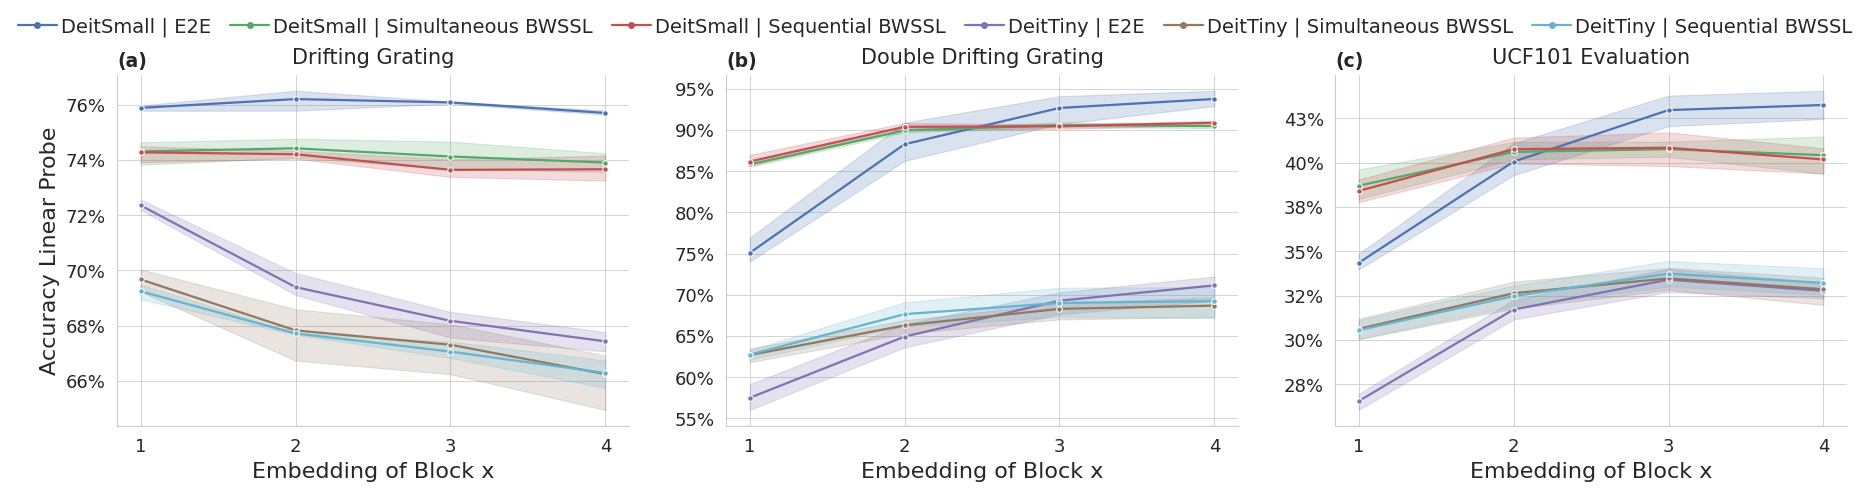

In [4]:
CLEAN_DATASET_NAMES = {
    "drifting_grating_dl": "Drifting Grating",
    "double_drifting_grating_dl": "Double Drifting Grating",
    "test_dl": "UCF101 Evaluation"
}

df_cp2 = df.copy()
df_cp2 = df_cp2[df_cp2["target_name"] == "Arithmetic Mean - Probe All Patches"]

df_cp2 = df_cp2[df_cp2["exp"].isin([28,29,30,36,37,38])] # for 4 Block runs
# df_cp2 = df_cp2[df_cp2["exp"].isin([40,41,42,46,47,48])] # for 6 Block runs


df_cp2["exp"] = df_cp2["exp"].astype("category")

EXP_LABEL = {
    28: "DeitSmall | E2E",
    29: "DeitSmall | Simultaneous BWSSL",
    30: "DeitSmall | Sequential BWSSL",
    36: "DeitTiny | E2E",
    37: "DeitTiny | Simultaneous BWSSL",
    38: "DeitTiny | Sequential BWSSL",
    46: "DeitSmall | E2E (Baseline) BWSSL",
    47: "DeitSmall | Simultaneous BWSSL",
    48: "DeitSmall | Sequential BWSSL",
    40: "DeitTiny | E2E (Baseline)",
    41: "DeitTiny | Simultaneous BWSSL",
    42: "DeitTiny | Sequential BWSSL",
}

df_cp2["exp_label"] = df_cp2["exp"].astype(int).map(EXP_LABEL)


exp_ids = [28, 29, 30, 36, 37, 38]
hue_order_exp = [EXP_LABEL[i] for i in exp_ids if i in EXP_LABEL]

cb9 = sns.color_palette([
    "#4C72B0",
    "#55A868",
    "#C44E52",
    "#8172B2",
    "#937860",
    "#64B5CD",
    "#2F4B7C",
    "#3D8A7B",
    "#6E6E6E",
])

exp_palette = dict(zip(hue_order_exp, cb9[:len(hue_order_exp)]))


g = sns.relplot(
    data=df_cp2,
    x="block_nr",
    y="target_val",
    hue="exp_label",
    hue_order=hue_order_exp,
    palette=exp_palette,
    kind="line",
    col="dataset",
    marker="o",
    facet_kws={"sharex": True, "sharey": False}
)


panel_letters = list("abc")

t = df_cp2["target_name"].iloc[0]

for i, (ax, o) in enumerate(zip(g.axes.flat, g.col_names)):
    ax.set_title("")

    ax.set_title(f"({panel_letters[i]})", loc="left", fontweight="bold")

    ax.text(
        0.5, 1.02, f"{CLEAN_DATASET_NAMES[o]}",
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=15
    )

g.fig.subplots_adjust(top=0.86, right=0.99)

g.set_axis_labels("Embedding of Block x", "Accuracy Linear Probe", fontsize=16)

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

leg = g._legend
handles = leg.legend_handles
labels = [t.get_text() for t in leg.texts]
leg.remove()

ncol = min(len(labels), 6)
g.fig.legend(
    handles, labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.99),
    ncol=ncol,
    frameon=False,
    title=None,
    handletextpad=0.2,
    columnspacing=1.0,
    fontsize=14
)

g.fig.subplots_adjust(top=0.84)

# plt.savefig("figures/feat_complexity.pdf", bbox_inches="tight")
plt.show()

In [5]:
def add_next_block_change(
    dfA: pd.DataFrame,
    dfB: pd.DataFrame,
    keys=("uuid", "dataset", "solver", "run_nr"),
    block_col="block_nr",
    value_col="target_val",
    new_col="target_change",
) -> pd.DataFrame:
    keys = list(keys)

    # --- Basic column checks ---
    needed_cols = set(keys + [block_col, value_col])
    missingA = needed_cols - set(dfA.columns)
    missingB = needed_cols - set(dfB.columns)
    if missingA:
        raise KeyError(f"dfA missing columns: {sorted(missingA)}")
    if missingB:
        raise KeyError(f"dfB missing columns: {sorted(missingB)}")

    b = dfB.copy()

    # --- Correctness checks (avoid ambiguous matches) ---
    # 1) There must be exactly one row per (keys, block_nr) in B
    dup_mask = b.duplicated(subset=keys + [block_col], keep=False)
    if dup_mask.any():
        examples = b.loc[dup_mask, keys + [block_col]].head(10)
        raise ValueError(
            "dfB has duplicate rows for the same (keys, block_nr). "
            "This makes the lookup ambiguous.\n"
            f"Examples:\n{examples}"
        )

    # Ensure block_col is numeric-ish and sortable; keep as int if possible
    b[block_col] = pd.to_numeric(b[block_col], errors="raise")

    # Sort so "next block" really means k+1 within each group
    b = b.sort_values(keys + [block_col])

    # 2) Optionally enforce that blocks are exactly 1..n with no gaps per group
    #    (If gaps are possible and you want to allow them, remove this whole check.)
    def _is_consecutive_1_to_n(s: pd.Series) -> bool:
        arr = s.to_numpy()
        if len(arr) == 0:
            return True
        return (arr[0] == 1) and np.array_equal(arr, np.arange(1, len(arr) + 1))

    bad_groups = (
        b.groupby(keys, sort=False)[block_col]
         .apply(_is_consecutive_1_to_n)
    )
    if (~bad_groups).any():
        bad = bad_groups[~bad_groups].index.tolist()[:10]
        raise ValueError(
            "Some groups in dfB do not have block_nr exactly 1..n with no gaps. "
            "Fix dfB or remove the consecutiveness check.\n"
            f"First bad groups (up to 10): {bad}"
        )

    # --- Compute change: (value at k+1) - (value at k) ---
    b[new_col] = b.groupby(keys, sort=False)[value_col].shift(-1) - b[value_col]

    # Keep only blocks 1..n-1 (last block has no 'next', so change is NaN)
    b_adapted = b.dropna(subset=[new_col])[[*keys, block_col, new_col]]
    
    # --- Merge into A ---
    # validate='m:1' means: many rows in A can match exactly one row in B_adapted

    keys_to_merge = [x for x in keys if x != "solver"]
    
    out = dfA.merge(
        b_adapted,
        on=[*keys_to_merge, block_col],
        how="left",
        validate="1:1"
    )

    return out


/tmp/ipykernel_29898/2344557937.py:105: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([trans_map.get(l, l) for l in labs])


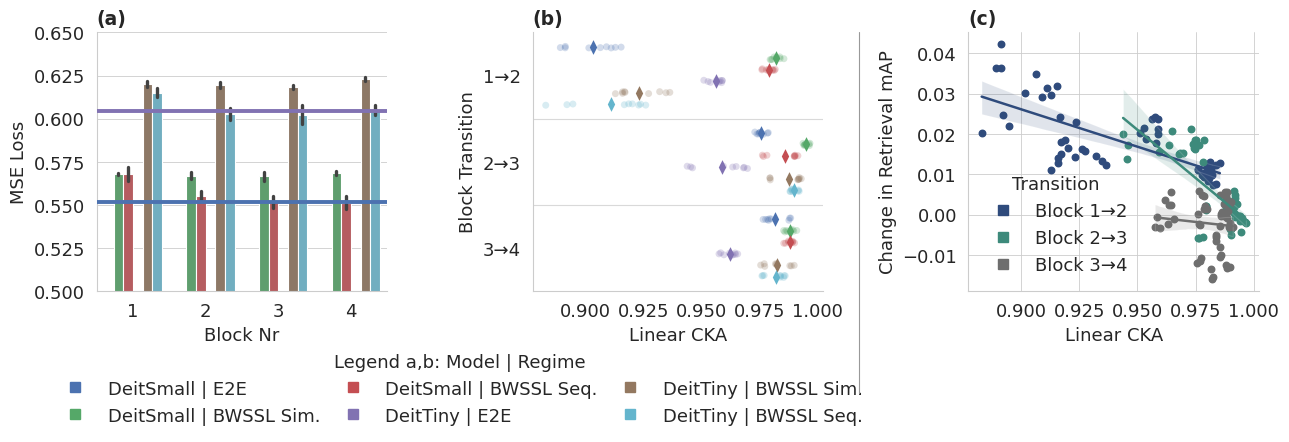

In [6]:
TARGET_NAME_LABEL = {
    "Loss": "MSE Loss",
    "Arithmetic Mean - Probe All Patches": "Acc. Lin. Probe",
    "retrieval_map": "Retrieval Map",
}

def three_panel_row(
    df: pd.DataFrame,
    target_name: str,
    x: str = "block_nr",
    y: str = "target_val",
    hue: str = "exp",
    dataset: str = "test_dl",
    baseline_label: str = "E2E Baseline",
    figsize=(12.5, 3.8),
):
    d = df.copy()

    fig, axes = plt.subplots(1, 3, figsize=figsize, gridspec_kw={"wspace": 0.5})
    panel_letters = list("abc")

    dataset_text = dataset if dataset is not None else (d["dataset"].iloc[0] if "dataset" in d.columns and not d.empty else "")
    target_text = TARGET_NAME_LABEL.get(target_name, target_name)

    
    regimes = sorted(pd.unique(d[hue].dropna()))

    EXP_LABEL = {
        28: "DeitSmall | E2E",
        29: "DeitSmall | BWSSL Sim.",
        30: "DeitSmall | BWSSL Seq.",
        36: "DeitTiny | E2E",
        37: "DeitTiny | BWSSL Sim.",
        38: "DeitTiny | BWSSL Seq.",
        # 46: "DeitSmall | E2E",
        # 47: "DeitSmall | BWSSL Sim.",
        # 48: "DeitSmall | BWSSL Seq.",
        # 40: "DeitTiny | E2E",
        # 41: "DeitTiny | BWSSL Sim.",
        # 42: "DeitTiny | BWSSL Seq.",
    }

    exp_ids = [28, 29, 30, 36, 37, 38]
    hue_order_exp = [EXP_LABEL[i] for i in exp_ids if i in EXP_LABEL]

    cb9 = paper9 = sns.color_palette([
        "#4C72B0",
        "#55A868",
        "#C44E52",
        "#8172B2",
        "#937860",
        "#64B5CD",
        "#2F4B7C",
        "#3D8A7B",
        "#6E6E6E",
    ])
    
    exp_palette = dict(zip(hue_order_exp, cb9[:len(hue_order_exp)]))

    block_colors = cb9[6:9]

    # ---------- Panel B:  (exclude baseline bars; show baseline as horizontal line) ----------
    ax = axes[1]
    p1_x = "target_val"
    p1_y = "block_nr"
    p1_hue = "regime"
    p1_target = "linear_cka"
    
    d_1 = d[d["target_name"] == p1_target].copy()

    d_1 = d_1[d_1["exp"].isin([28,29,30,36,37,38])] #,40,41,42,46,47,48])]

    
    d_1["y_cat"] = d_1[p1_y].astype(str)

    d_1["exp_label"] = d_1["exp"].astype(int).map(EXP_LABEL)

    sns.stripplot(
        data=d_1,
        x=p1_x,
        y="y_cat",
        hue="exp_label",
        hue_order=hue_order_exp,
        palette=exp_palette,
        dodge=True, alpha=.25, zorder=1, legend=False,
        ax=ax,
    )
    
    sns.pointplot(
        data=d_1, x=p1_x, y="y_cat", hue="exp_label",
        hue_order=hue_order_exp,
        dodge=.8 - .8 / 6, palette=exp_palette, errorbar=None,
        markers="d", markersize=4, linestyle="none",
        legend=False,
        ax=ax
    )


    ax.set_xlabel("Linear CKA")
    ax.set_ylabel("Block Transition")  # we'll add a shared ylabel later
    ax.set_title(f"({panel_letters[1]})", loc="left", fontweight="bold")

    labs = [t.get_text() for t in ax.get_yticklabels()]
    trans_map = {"1": "1→2", "2": "2→3", "3": "3→4"}
    ax.set_yticklabels([trans_map.get(l, l) for l in labs])

    ax.grid(False)
    yt = np.asarray(ax.get_yticks(), dtype=float)
    if yt.size >= 2:
        for y in (yt[:-1] + yt[1:]) / 2.0:
            ax.axhline(y, color="0.85", lw=0.8, zorder=0)


    # ---------- Panel C: regression ----------
    ax = axes[2]

    p3_x = "target_val"
    p3_y = "block_nr"
    p3_hue = "regime"
    p3_target = "linear_cka"
    
    d_3_1 = d[d["target_name"] == p3_target].copy()
    d_3_2 = d[d["target_name"] == "retrieval_map"].copy()

    
    d_3 = add_next_block_change(
        d_3_1,
        d_3_2,
        keys=("uuid", "dataset", "solver", "run_nr"),
        block_col="block_nr",
        value_col="target_val",
        new_col="target_change",
    )
    
    d_3 = d_3[d_3["exp"].isin([28,29,30,36,37,38])]
    
    d_3["y_cat"] = d_3[p3_y].astype(str)

    d_3["exp_label"] = d_3["exp"].astype(int).map(EXP_LABEL)

    
    for r in [1,2,3]:
        sub = d_3[d_3["block_nr"] == r]
        if sub.empty:
            continue
        sns.regplot(
            data=sub,
            x="target_val",
            y="target_change",
            ax=ax,
            color=block_colors[r-1],
            scatter=True,
            ci=95,  # set to None if you want absolutely no bands
            scatter_kws={"s": 22, "alpha": 1.0},
            line_kws={"lw": 1.8},
        )

    block_levels = [1,2,3]
    handles_c = [
        Line2D([0], [0],
               marker="s", linestyle="none",
               markersize=7,
               markerfacecolor=block_colors[i],
               markeredgecolor=block_colors[i])
        for i in range(len(block_levels))
    ]
    labels_c = [f"Block {r}→{r+1}" for r in block_levels]
    ax.legend(handles_c, labels_c, title="Transition", frameon=False, loc="best")
    
    ax.set_xlabel("Linear CKA")
    ax.set_ylabel("Change in Retrieval mAP")
    ax.set_title(f"({panel_letters[2]})", loc="left", fontweight="bold")


    # ---------- Panel A: Barplot ----------
    ax = axes[0]
    p2_x = "target_val"
    p2_y = "block_nr"
    p2_hue = "regime"
    p2_target = "Loss"
    
    d_2 = d[d["target_name"] == p2_target].copy()

    d_2 = d_2[d_2["exp"].isin([28,29,30,36,37,38])] #,40,41,42,46,47,48])]

    mask = d_2["regime"] == "e2e_attached"
    d_2.loc[mask, "block_nr"] = 1

    d_2["y_cat"] = d_2[p2_y].astype(str)

    d_2["exp_label"] = d_2["exp"].astype(int).map(EXP_LABEL)

    sub_line = d_2[d_2["regime"] == "e2e_attached"].copy()
    sub_bar  = d_2[d_2["regime"] != "e2e_attached"].copy()

    regimes = sorted(pd.unique(d_2["regime"].dropna()))
    palette = dict(zip(regimes, sns.color_palette(n_colors=len(regimes))))
    
    sub_bar["block_nr_cat"] = sub_bar["block_nr"].astype(str)
    block_order_sub = [str(b) for b in sorted(sub_bar["block_nr"].dropna().unique())]
    hue_order_sub = sorted(sub_bar["regime"].dropna().unique())

    sns.barplot(
        data=sub_bar,
        x="block_nr_cat",
        y="target_val",
        hue="exp_label",
        hue_order=hue_order_exp,
        palette=exp_palette,
        estimator="mean",
        errorbar=("ci", 95),
        legend=False,
        ax=ax,
    )


    
    if not sub_line.empty:
        # one baseline per baseline exp_label; color matches panel (b)
        base = (sub_line.groupby("exp_label", as_index=False)["target_val"].mean())

        for _, row in base.iterrows():
            lab = row["exp_label"]
            if lab not in exp_palette:   # safety if something is missing
                continue
            ax.axhline(row["target_val"], color=exp_palette[lab], linewidth=2.8, alpha=1.0, zorder=5)



    ax.set_ylim(0.5, 0.65)
    
    ax.set_ylabel("MSE Loss")
    ax.set_xlabel("Block Nr")  # we'll add a shared ylabel later
    ax.set_title(f"({panel_letters[0]})", loc="left", fontweight="bold")


    legend_order = [
        "DeitSmall | E2E",
        "DeitSmall | BWSSL Sim.",
        "DeitSmall | BWSSL Seq.",
        "DeitTiny | E2E",
        "DeitTiny | BWSSL Sim.",
        "DeitTiny | BWSSL Seq.",
    ]

    handles_ab, labels_ab = [], []
    for lab in legend_order:
        if lab not in exp_palette:
            continue
        handles_ab.append(
            Line2D([0], [0],
                   marker="s", linestyle="none",
                   markersize=7,
                   markerfacecolor=exp_palette[lab],
                   markeredgecolor=exp_palette[lab])
        )
        labels_ab.append(lab)

    pos0 = axes[0].get_position()
    pos1 = axes[1].get_position()
    x_center_ab = 0.5 * (pos0.x0 + pos1.x1)
    y_bottom_ab = min(pos0.y0, pos1.y0)
    y_leg_top = y_bottom_ab - 0.03

    fig.legend(
        handles_ab, labels_ab,
        title="Legend a,b: Model | Regime",
        loc="upper center",
        bbox_to_anchor=(x_center_ab, y_bottom_ab - 0.03),
        bbox_transform=fig.transFigure,
        ncol=3,
        frameon=False,
        columnspacing=0.8,
    )

    # make room for the bottom legend
    fig.subplots_adjust(bottom=0.2)

    
    pos_b = axes[1].get_position()
    pos_c = axes[2].get_position()

    gap = pos_c.x0 - pos_b.x1
    x_sep = pos_b.x1 + 0.25 * gap   # shift left to avoid panel (c) ylabel region

    y0 = y_leg_top - 0.15                 # extend down to the top edge of the (a–b) legend
    y1 = max(pos_b.y1, pos_c.y1)

    fig.add_artist(Line2D(
        [x_sep, x_sep], [y0, y1],
        transform=fig.transFigure,
        color="0.6", lw=0.8, zorder=10
    ))
    
    return fig, axes

df_cp = df.copy()
df_cp = df_cp[df_cp["dataset"] == "test_dl"]


fig, axes = three_panel_row(
    df_cp,
    target_name="Arithmetic Mean - Probe All Patches",
    dataset="test_dl",
    figsize=(15, 3.8)
)

# fig.savefig("figures/loss_and_cka.pdf", bbox_inches="tight")

plt.show()

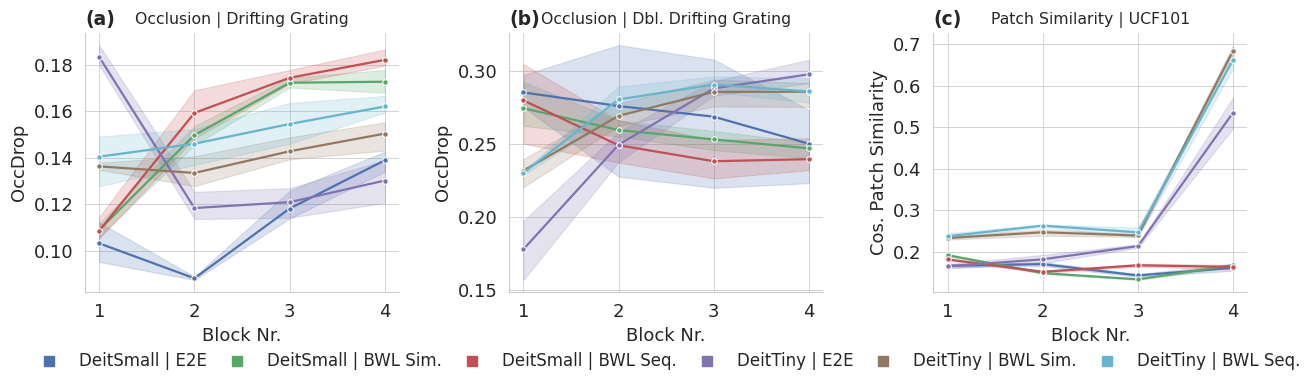

In [7]:
df_3_1 = df[df["target_name"] == "Arithmetic Mean - Probe All Patches"].copy()
df_3_2 = df[df["target_name"] == "Arithmetic Mean - Probe One Patch"].copy()

group_keys = df.columns.tolist()
group_keys.remove("target_name")
group_keys.remove("target_val")
group_keys.remove("run_nr")
group_keys.remove("res")


all_patches_grouped = df_3_1.groupby(group_keys)["target_val"].mean()
one_patch_grouped = df_3_2.groupby(group_keys)["target_val"].mean()

occl_diff = ((all_patches_grouped-one_patch_grouped)/all_patches_grouped).reset_index()
occl_diff["target_name"] = "Linear Probe Patch Diff."


d = df.copy()
d = d[d["dataset"] == "test_dl"]

figsize=(15, 3.8)
fig, axes = plt.subplots(1, 3, figsize=figsize, gridspec_kw={"wspace": 0.35})
panel_letters = list("abc")

dataset="test_dl"
dataset_text = dataset if dataset is not None else (d["dataset"].iloc[0] if "dataset" in d.columns and not d.empty else "")

EXP_LABEL = {
    28: "DeitSmall | E2E",
    29: "DeitSmall | BWL Sim.",
    30: "DeitSmall | BWL Seq.",
    36: "DeitTiny | E2E",
    37: "DeitTiny | BWL Sim.",
    38: "DeitTiny | BWL Seq.",
    # 46: "DeitSmall | E2E",
    # 47: "DeitSmall | BWL Sim.",
    # 48: "DeitSmall | BWL Seq.",
    # 40: "DeitTiny | E2E",
    # 41: "DeitTiny | BWL Sim.",
    # 42: "DeitTiny | BWL Seq.",
}

exp_ids = [28, 29, 30, 36, 37, 38]
hue_order_exp = [EXP_LABEL[i] for i in exp_ids if i in EXP_LABEL]

cb9 = paper9 = sns.color_palette([
    "#4C72B0",
    "#55A868",
    "#C44E52",
    "#8172B2",
    "#937860",
    "#64B5CD",
    "#2F4B7C",
    "#3D8A7B",
    "#6E6E6E",
])

exp_palette = dict(zip(hue_order_exp, cb9[:len(hue_order_exp)]))


# ---------- Panel A: LINEPLOT ----------

ax = axes[0]
p1_x = "block_nr"
p1_y = "target_val"
p1_hue = "regime"
p1_target = "Linear Probe Patch Diff."
    
d_1 = occl_diff[occl_diff["target_name"] == p1_target].copy()
d_1 = d_1[d_1["exp"].isin([28,29,30,36,37,38])]

d_1 = d_1[d_1["dataset"] == "drifting_grating_dl"]


d_1["x_cat"] = d_1[p1_x].astype(str)
d_1["exp_label"] = d_1["exp"].astype(int).map(EXP_LABEL)

g = sns.lineplot(
    data=d_1,
    x="x_cat",
    y=p1_y,
    hue="exp_label",
    hue_order=hue_order_exp,
    palette=exp_palette,
    legend=False,
    marker="o",
    ax=ax,
)
ax.set_xlabel("Block Nr.")
ax.set_ylabel("OccDrop")
ax.set_title(f"({panel_letters[0]})", loc="left", fontweight="bold")
ax.text(
        0.5, 1.02, "Occlusion | Drifting Grating", # | {t}",
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=11.3
    )

# ---------- Panel B: LINEPLOT ----------

ax = axes[1]
p1_x = "block_nr"
p1_y = "target_val"
p1_hue = "regime"
p1_target = "Linear Probe Patch Diff."
    
d_1 = occl_diff[occl_diff["target_name"] == p1_target].copy()
d_1 = d_1[d_1["exp"].isin([28,29,30,36,37,38])]

d_1 = d_1[d_1["dataset"] == "double_drifting_grating_dl"] # drifting_grating_dl


d_1["x_cat"] = d_1[p1_x].astype(str)
d_1["exp_label"] = d_1["exp"].astype(int).map(EXP_LABEL)

g = sns.lineplot(
    data=d_1,
    x="x_cat",
    y=p1_y,
    hue="exp_label",
    hue_order=hue_order_exp,
    palette=exp_palette,
    legend=False,
    marker="o",
    ax=ax,
)
ax.set_xlabel("Block Nr.")
ax.set_ylabel("OccDrop")
ax.set_title(f"({panel_letters[1]})", loc="left", fontweight="bold")
ax.text(
        0.5, 1.02, "Occlusion | Dbl. Drifting Grating", # | {t}",
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=11.3
    )


# ---------- Panel C: LINEPLOT ----------
ax = axes[2]
p2_x = "block_nr"
p2_y = "target_val"
p2_hue = "regime"
p2_target = "Cos. Patch Similarity"
    
d_2 = d[d["target_name"] == p2_target].copy()
d_2 = d_2[d_2["exp"].isin([28,29,30,36,37,38])]
d_2["x_cat"] = d_2[p2_x].astype(str)
d_2["exp_label"] = d_2["exp"].astype(int).map(EXP_LABEL)

g = sns.lineplot(
    data=d_2,
    x="x_cat",
    y=p2_y,
    hue="exp_label",
    hue_order=hue_order_exp,
    palette=exp_palette,
    legend=False,
    marker="o",
    ax=ax,
)
ax.set_xlabel("Block Nr.")
ax.set_ylabel("Cos. Patch Similarity")
ax.set_title(f"({panel_letters[2]})", loc="left", fontweight="bold")
ax.text(
        0.5, 1.02, "Patch Similarity | UCF101", # | {t}",
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=11.3
    )


legend_order = [
    "DeitSmall | E2E",
    "DeitSmall | BWL Sim.",
    "DeitSmall | BWL Seq.",
    "DeitTiny | E2E",
    "DeitTiny | BWL Sim.",
    "DeitTiny | BWL Seq.",
]


handles_ab, labels_ab = [], []
for lab in legend_order:
    if lab not in exp_palette:
        continue
    handles_ab.append(
        Line2D([0], [0],
                marker="s", linestyle="none",
               markersize=7,
               markerfacecolor=exp_palette[lab],
               markeredgecolor=exp_palette[lab])
    )
    labels_ab.append(lab)

pos0 = axes[0].get_position()
pos1 = axes[2].get_position()
x_center_ab = 0.5 * (pos0.x0 + pos1.x1)
y_bottom_ab = min(pos0.y0, pos1.y0)
y_leg_top = y_bottom_ab - 0.03

fig.legend(
    handles_ab, labels_ab,
    # title="Legend a,b: Model | Regime",
    loc="upper center",
    bbox_to_anchor=(x_center_ab, y_bottom_ab - 0.03),
    bbox_transform=fig.transFigure,
    ncol=6,
    frameon=False,
    columnspacing=0.8,
    fontsize=12
)

fig.subplots_adjust(bottom=0.2)

# fig.savefig("figures/patch_level.pdf", bbox_inches="tight")
plt.show()